In [2]:
import requests
import pandas as pd 
import io 
subway_ridership_endpoint = 'https://data.ny.gov/resource/jsu2-fbtj.csv'
r_outbound=requests.get(
        url = subway_ridership_endpoint, 
        params={
            '$select':'timestamp,origin_station_complex_name as name,SUM(estimated_average_ridership) as outbound_ridership',
            '$where':"origin_station_complex_id in (82,192)",
            '$group':'timestamp,origin_station_complex_name',
            '$order':'timestamp',
            '$limit':50000
        }
    )
assert r_outbound.status_code == 200
outbound = pd.read_csv(io.StringIO(r_outbound.text))

r_inbound = requests.get(
        url = subway_ridership_endpoint, 
        params={
            '$select':'timestamp,destination_station_complex_name as name,SUM(estimated_average_ridership) as inbound_ridership',
            '$where':"destination_station_complex_id in (82,192)",
            '$group':'timestamp,destination_station_complex_name',
            '$order':'timestamp',
            '$limit':50000
        }
    )
assert r_inbound.status_code == 200
inbound = pd.read_csv(io.StringIO(r_inbound.text))

combined_hub_ridership = outbound.merge(
    inbound, 
    how='inner', 
    on=['timestamp','name']
)

combined_hub_ridership.head(10)

,timestamp,name,outbound_ridership,inbound_ridership
0,2024-01-08T00:00:00.000,"104 St (J,Z)",5.6004,20.0402
1,2024-01-08T00:00:00.000,Rockaway Blvd (A),13.6006,35.8042
2,2024-01-08T01:00:00.000,"104 St (J,Z)",5.2000,11.6978
3,2024-01-08T01:00:00.000,Rockaway Blvd (A),10.8000,19.1504
4,2024-01-08T02:00:00.000,"104 St (J,Z)",4.2002,4.7990
5,2024-01-08T02:00:00.000,Rockaway Blvd (A),10.1998,11.1592
6,2024-01-08T03:00:00.000,"104 St (J,Z)",6.3998,3.2538
7,2024-01-08T03:00:00.000,Rockaway Blvd (A),18.6012,13.3050
8,2024-01-08T04:00:00.000,"104 St (J,Z)",24.5998,8.1644
9,2024-01-08T04:00:00.000,Rockaway Blvd (A),74.9998,18.5556


In [4]:
station_metadata=pd.read_csv('datasets/MTA_Subway_Entrances_and_Exits__2024_20250417.csv')
qns_stations = station_metadata.loc[
    (station_metadata['Borough']=='Q')
   &(~station_metadata['Daytime Routes'].str.contains('A|C|J|Z'))
]
qns_stations_tr = qns_stations[['Stop Name','Complex ID','Daytime Routes']].drop_duplicates()
qns_stations_lst = ','.join(qns_stations['Complex ID'].unique().astype(str))

r_outbound_qns_only=requests.get(
        url = subway_ridership_endpoint, 
        params={
            '$select':'timestamp,origin_station_complex_name as name,SUM(estimated_average_ridership) as outbound_ridership_qns_only',
            '$where':f"origin_station_complex_id in (82,192) and destination_station_complex_id in ({qns_stations_lst})",
            '$group':'timestamp,origin_station_complex_name',
            '$order':'timestamp',
            '$limit':50000
        }
    )
assert r_outbound_qns_only.status_code == 200
outbound_qns_only = pd.read_csv(io.StringIO(r_outbound_qns_only.text))

r_inbound_qns_only = requests.get(
        url = subway_ridership_endpoint, 
        params={
            '$select':'timestamp,destination_station_complex_name as name,SUM(estimated_average_ridership) as inbound_ridership_qns_only',
            '$where':f"destination_station_complex_id in (82,192) and origin_station_complex_id in ({qns_stations_lst})",
            '$group':'timestamp,destination_station_complex_name',
            '$order':'timestamp',
            '$limit':50000
        }
    )
assert r_inbound_qns_only.status_code == 200
inbound_qns_only = pd.read_csv(io.StringIO(r_inbound_qns_only.text))

combined_hub_ridership_qns_only = outbound_qns_only.merge(
    inbound_qns_only, 
    how='inner', 
    on=['timestamp','name']
)

combined_hub_ridership_w_qns_only = \
pd.concat((
    combined_hub_ridership.set_index(['timestamp','name']),
    combined_hub_ridership_qns_only.set_index(['timestamp','name'])
),axis=1)\
.fillna(0.0)

combined_hub_ridership_w_qns_only.head(10)

outbound_ridership  \
timestamp               name                                    
2024-01-08T00:00:00.000 104 St (J,Z)                   5.6004   
                        Rockaway Blvd (A)             13.6006   
2024-01-08T01:00:00.000 104 St (J,Z)                   5.2000   
                        Rockaway Blvd (A)             10.8000   
2024-01-08T02:00:00.000 104 St (J,Z)                   4.2002   
                        Rockaway Blvd (A)             10.1998   
2024-01-08T03:00:00.000 104 St (J,Z)                   6.3998   
                        Rockaway Blvd (A)             18.6012   
2024-01-08T04:00:00.000 104 St (J,Z)                  24.5998   
                        Rockaway Blvd (A)             74.9998   

                                           inbound_ridership  \
timestamp               name                                   
2024-01-08T00:00:00.000 104 St (J,Z)                 20.0402   
                        Rockaway Blvd (A)            35.8042   
2024-01-08T01:00:00.000 104 St (J,Z)                 11.6978   
                        Rockaway Blvd (A)            19.1504   
2024-01-08T02:00:00.000 104 St (J,Z)                  4.7990   
                        Rockaway Blvd (A)            11.1592   
2024-01-08T03:00:00.000 104 St (J,Z)                  3.2538   
                        Rockaway Blvd (A)            13.3050   
2024-01-08T04:00:00.000 104 St (J,Z)                  8.1644   
                        Rockaway Blvd (A)            18.5556   

                                           outbound_ridership_qns_only  \
timestamp               name                                             
2024-01-08T00:00:00.000 104 St (J,Z)                            1.0836   
                        Rockaway Blvd (A)                       2.1904   
2024-01-08T01:00:00.000 104 St (J,Z)                            1.1000   
                        Rockaway Blvd (A)                       1.1810   
2024-01-08T02:00:00.000 104 St (J,Z)                            0.2000   
                        Rockaway Blvd (A)                       1.6334   
2024-01-08T03:00:00.000 104 St (J,Z)                            0.2154   
                        Rockaway Blvd (A)                       0.6334   
2024-01-08T04:00:00.000 104 St (J,Z)                            1.8004   
                        Rockaway Blvd (A)                       2.4510   

                                           inbound_ridership_qns_only  
timestamp               name                                           
2024-01-08T00:00:00.000 104 St (J,Z)                           2.9082  
                        Rockaway Blvd (A)                      2.8672  
2024-01-08T01:00:00.000 104 St (J,Z)                           1.6780  
                        Rockaway Blvd (A)                      2.4630  
2024-01-08T02:00:00.000 104 St (J,Z)                           0.5640  
                        Rockaway Blvd (A)                      0.5296  
2024-01-08T03:00:00.000 104 St (J,Z)                           0.9214  
                        Rockaway Blvd (A)                      0.7818  
2024-01-08T04:00:00.000 104 St (J,Z)                           1.6890  
                        Rockaway Blvd (A)                      1.5048

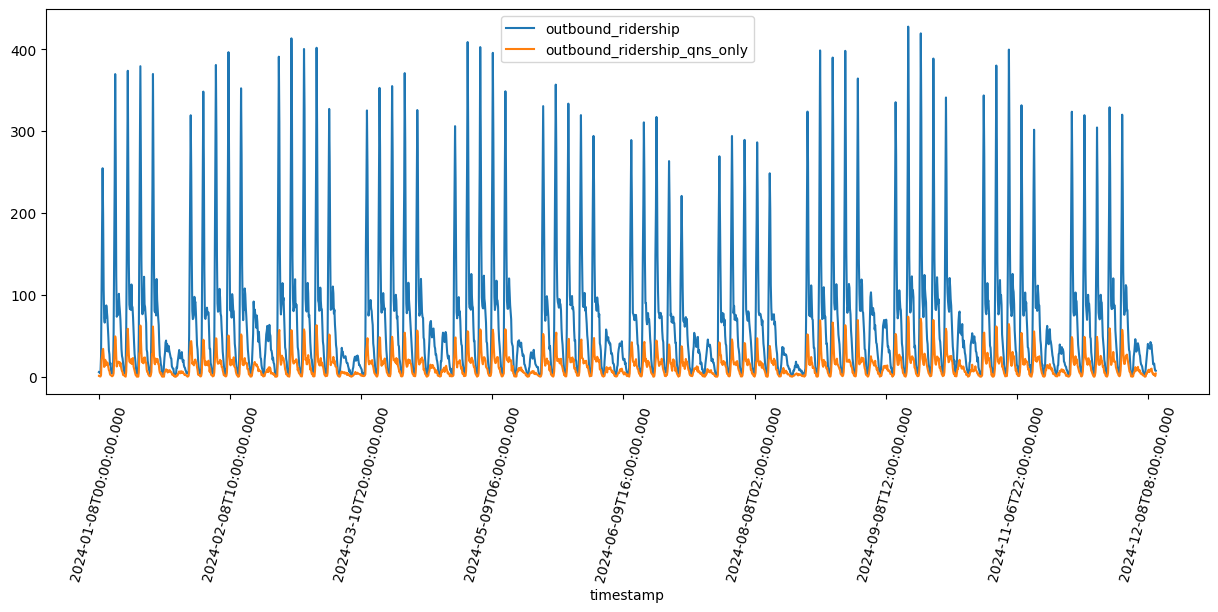

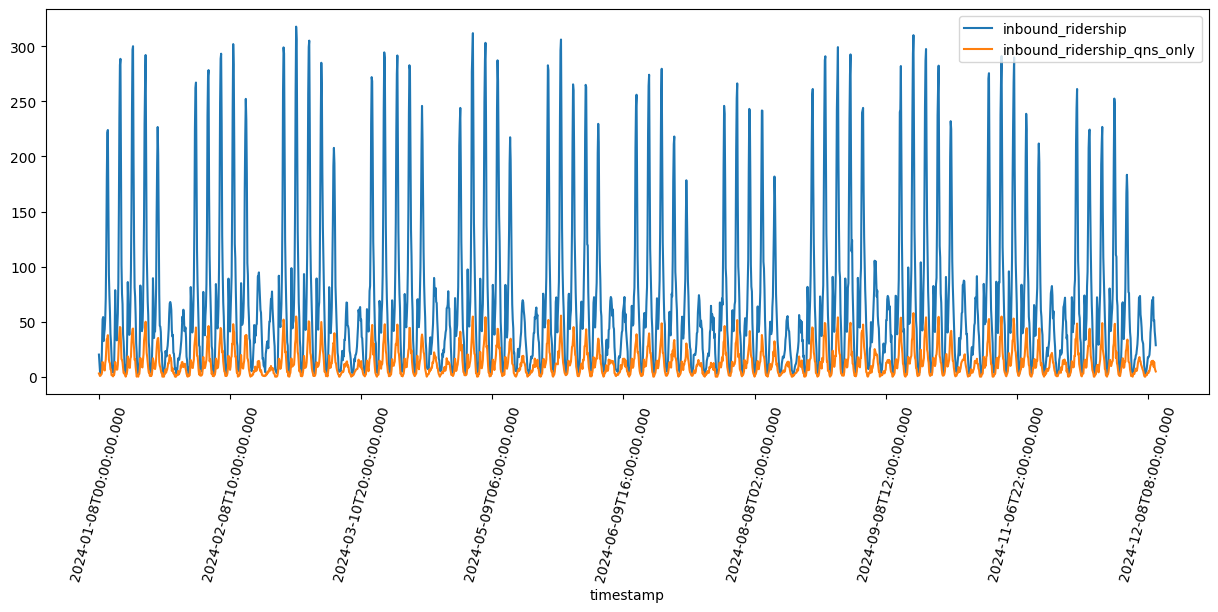

In [299]:
import matplotlib.pyplot as plt

rs = combined_hub_ridership_w_qns_only.reset_index()
s=rs.loc[rs['name'] == '104 St (J,Z)'].drop(columns=['name'])
s.set_index('timestamp')[['outbound_ridership','outbound_ridership_qns_only']].plot(figsize=(15,5))
plt.xticks(rotation=75)
plt.show()

s.set_index('timestamp')[['inbound_ridership','inbound_ridership_qns_only']].plot(figsize=(15,5))
plt.xticks(rotation=75)
plt.show()


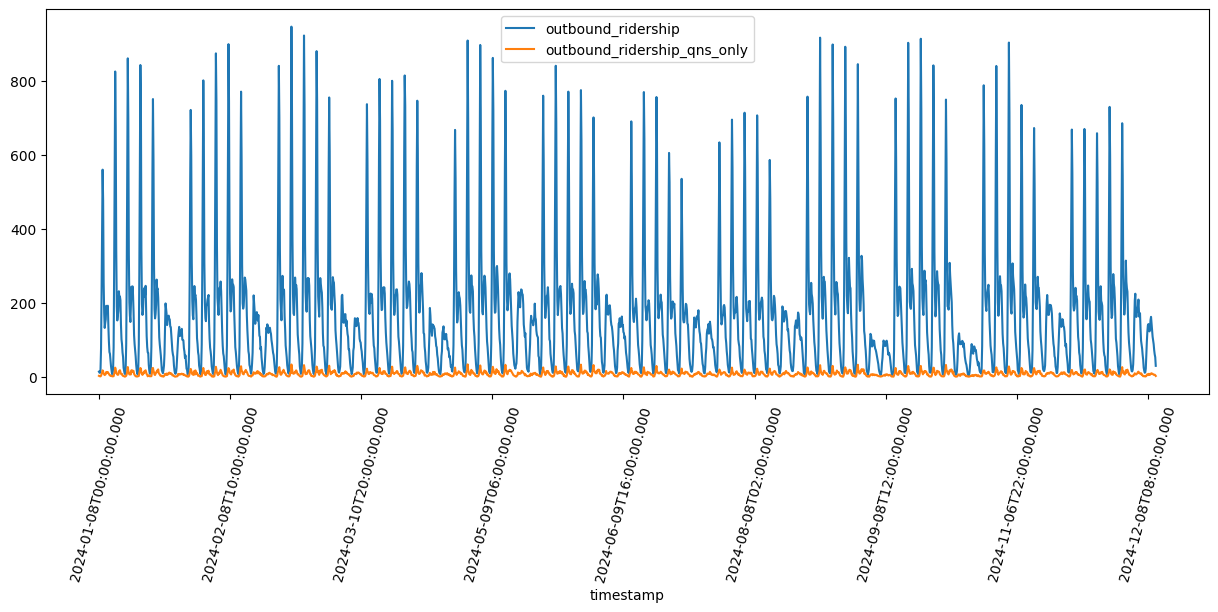

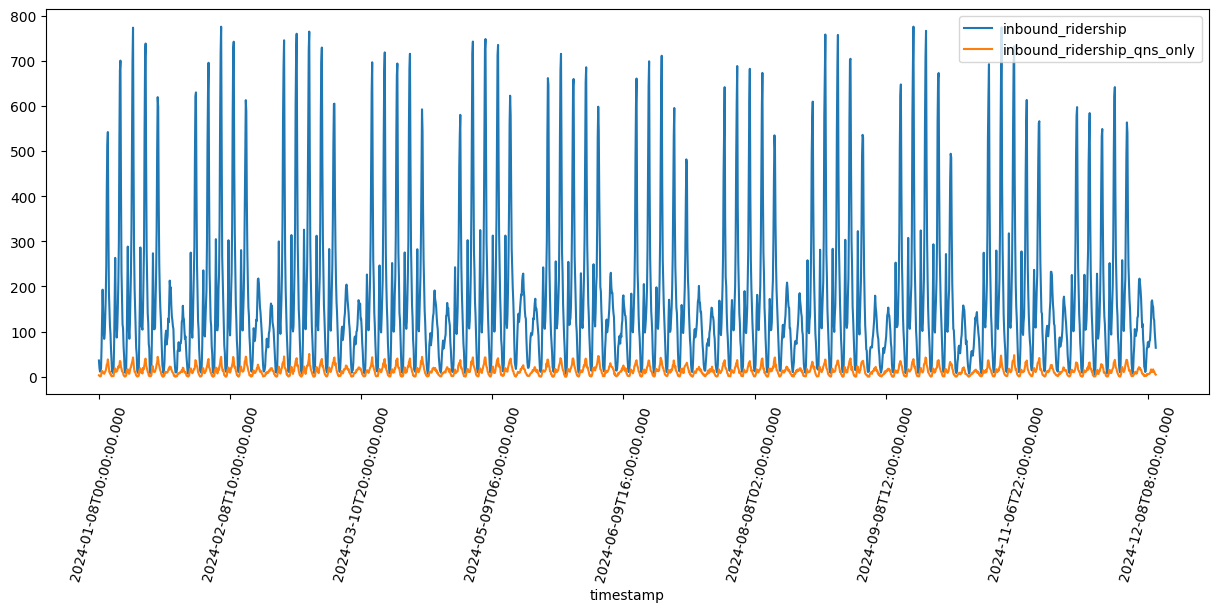

In [301]:
s=rs.loc[rs['name'] == 'Rockaway Blvd (A)'].drop(columns=['name'])
s.set_index('timestamp')[['outbound_ridership','outbound_ridership_qns_only']].plot(figsize=(15,5))
plt.xticks(rotation=75)
plt.show()

s.set_index('timestamp')[['inbound_ridership','inbound_ridership_qns_only']].plot(figsize=(15,5))
plt.xticks(rotation=75)
plt.show()

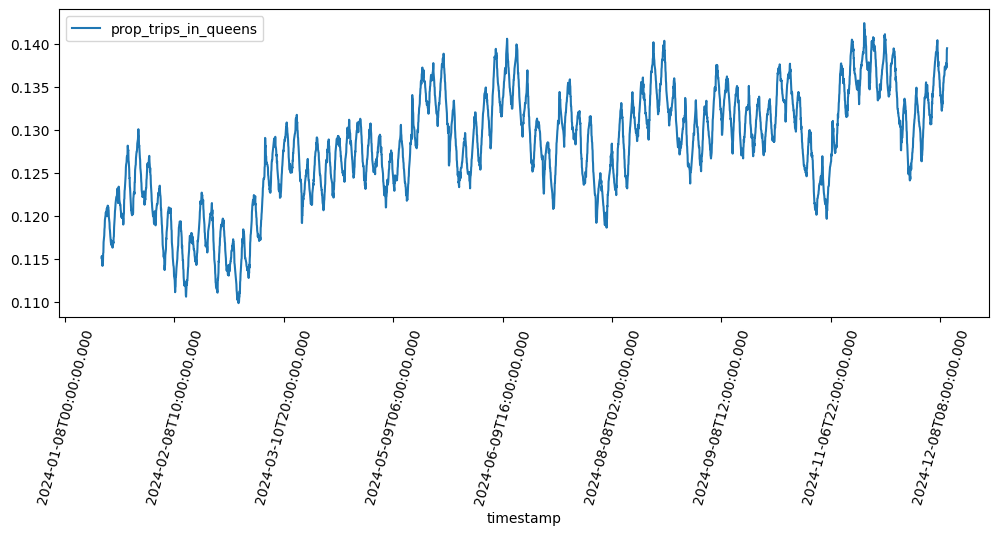

In [303]:
rs['prop_trips_in_queens'] = rs['outbound_ridership_qns_only']/rs['outbound_ridership']
rs.set_index('timestamp')[['prop_trips_in_queens']].rolling(24*7).mean().plot(figsize=(12,4))
plt.xticks(rotation=75)
plt.show()

In [276]:
##### info on transfers...don't run this as data is deprecated. use the OD pair estimates instead...

subway_ridership_endpoint_deprecated = 'https://data.ny.gov/resource/wujg-7c2s.csv'
r_transfers=requests.get(
        url = subway_ridership_endpoint_deprecated, 
        params={
            '$select':'transit_timestamp, station_complex, SUM(ridership) as ttl_ridership, SUM(transfers) as ttl_transfers',
            '$where':"station_complex_id in ('82','192')",
            '$group':'transit_timestamp,station_complex',
            '$order':'transit_timestamp',
            '$limit':100000
        }
    )

assert r_transfers.status_code == 200
w_transfers = pd.read_csv(io.StringIO(r_transfers.text))

w_transfers

,transit_timestamp,station_complex,ttl_ridership,ttl_transfers
0,2020-07-01T00:00:00.000,Rockaway Blvd (A),6.0,0.0
1,2020-07-01T04:00:00.000,"104 St (J,Z)",5.0,0.0
2,2020-07-01T04:00:00.000,Rockaway Blvd (A),75.0,1.0
3,2020-07-01T05:00:00.000,"104 St (J,Z)",108.0,0.0
4,2020-07-01T05:00:00.000,Rockaway Blvd (A),188.0,5.0
...,...,...,...,...
74048,2024-12-31T21:00:00.000,Rockaway Blvd (A),87.0,8.0
74049,2024-12-31T22:00:00.000,"104 St (J,Z)",26.0,0.0
74050,2024-12-31T22:00:00.000,Rockaway Blvd (A),38.0,0.0
74051,2024-12-31T23:00:00.000,"104 St (J,Z)",8.0,0.0


<Axes: xlabel='transit_timestamp'>

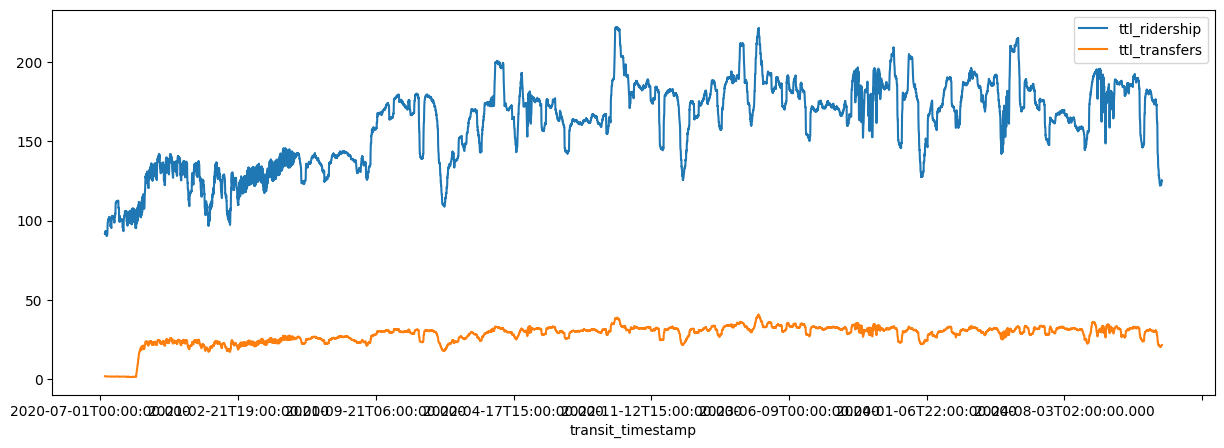

In [305]:
w_transfers\
    .loc[w_transfers['station_complex'] == 'Rockaway Blvd (A)']\
    .drop(columns=['station_complex'])\
    .set_index('transit_timestamp')\
    .rolling(24*7)\
    .mean()\
    .plot(figsize=(15,5))

<Axes: xlabel='transit_timestamp'>

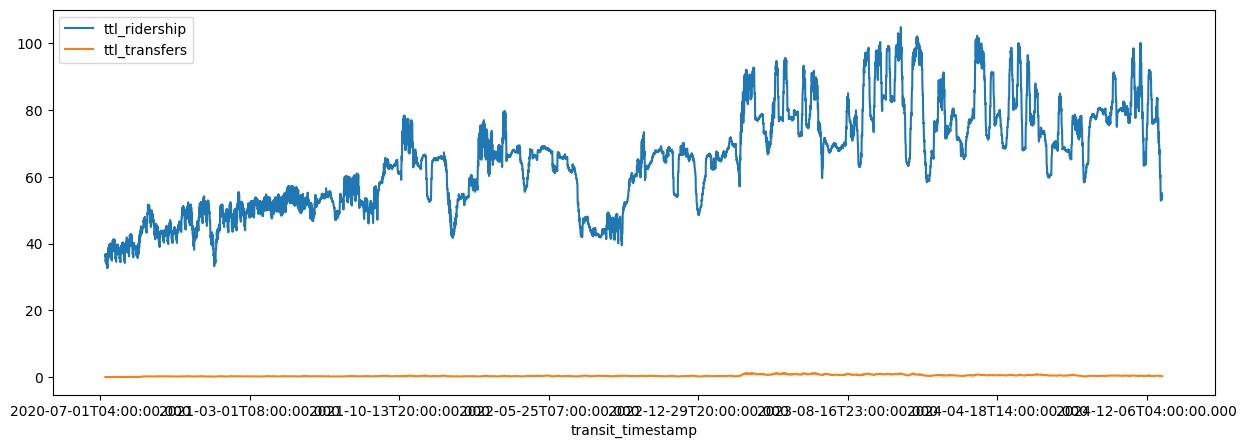

In [307]:
w_transfers\
    .loc[w_transfers['station_complex'] == '104 St (J,Z)']\
    .drop(columns=['station_complex'])\
    .set_index('transit_timestamp')\
    .rolling(24*7)\
    .mean()\
    .plot(figsize=(15,5))

#### Compute Inbound/Outbound/QNS-only demand for years 2022-2025

In [3]:
def compute_yearly(endpoint, station_id=['82','192']):

    def build_tbl(endpoint, payload):
        try:
            r = requests.get(
                url = endpoint, params = payload
            ) 
            return pd.read_csv(io.StringIO(r.text))
        except Exception: 
            print(r.status_code) 
            print(r.reason) 
            return pd.DataFrame() 
    stations_str = ','.join(station_id)
    payloads = [
        {
            '$select':'timestamp,origin_station_complex_name as name,SUM(estimated_average_ridership) as outbound_ridership',
            '$where':f"origin_station_complex_id in ({stations_str})",
            '$group':'timestamp,origin_station_complex_name',
            '$order':'timestamp',
            '$limit':50000
        }, 
        {
            '$select':'timestamp,destination_station_complex_name as name,SUM(estimated_average_ridership) as inbound_ridership',
            '$where':f"destination_station_complex_id in ({stations_str})",
            '$group':'timestamp,destination_station_complex_name',
            '$order':'timestamp',
            '$limit':50000
        }, 
        {
            '$select':'timestamp,origin_station_complex_name as name,SUM(estimated_average_ridership) as outbound_ridership_qns_only',
            '$where':f"origin_station_complex_id in ({stations_str}) and destination_station_complex_id in ({qns_stations_lst})",
            '$group':'timestamp,origin_station_complex_name',
            '$order':'timestamp',
            '$limit':50000
        }, 
        {
            '$select':'timestamp,destination_station_complex_name as name,SUM(estimated_average_ridership) as inbound_ridership_qns_only',
            '$where':f"destination_station_complex_id in ({stations_str}) and origin_station_complex_id in ({qns_stations_lst})",
            '$group':'timestamp,destination_station_complex_name',
            '$order':'timestamp',
            '$limit':50000
        }
        
    ]
            
    return pd.concat([build_tbl(endpoint = endpoint, payload = i).set_index(['timestamp','name']) for i in payloads],axis=1)

endpoints_by_yr = [
'https://data.ny.gov/resource/rapa-97zv.csv', 
'https://data.ny.gov/resource/nqnz-e9z9.csv', 
'https://data.ny.gov/resource/uhf3-t34z.csv',
'https://data.ny.gov/resource/jsu2-fbtj.csv',
'https://data.ny.gov/resource/y2qv-fytt.csv'
]

from tqdm import tqdm
ttl=[]
for idx,en in tqdm(enumerate(endpoints_by_yr)):
    print(f'*** LOADING 202{idx+1} SUBWAY RIDERSHIP DEMAND TS DATA ***') 
    ttl.append(compute_yearly(en))
    

0it [00:00, ?it/s]

*** LOADING 2021 SUBWAY RIDERSHIP DEMAND TS DATA ***


NameError: name 'qns_stations_lst' is not defined

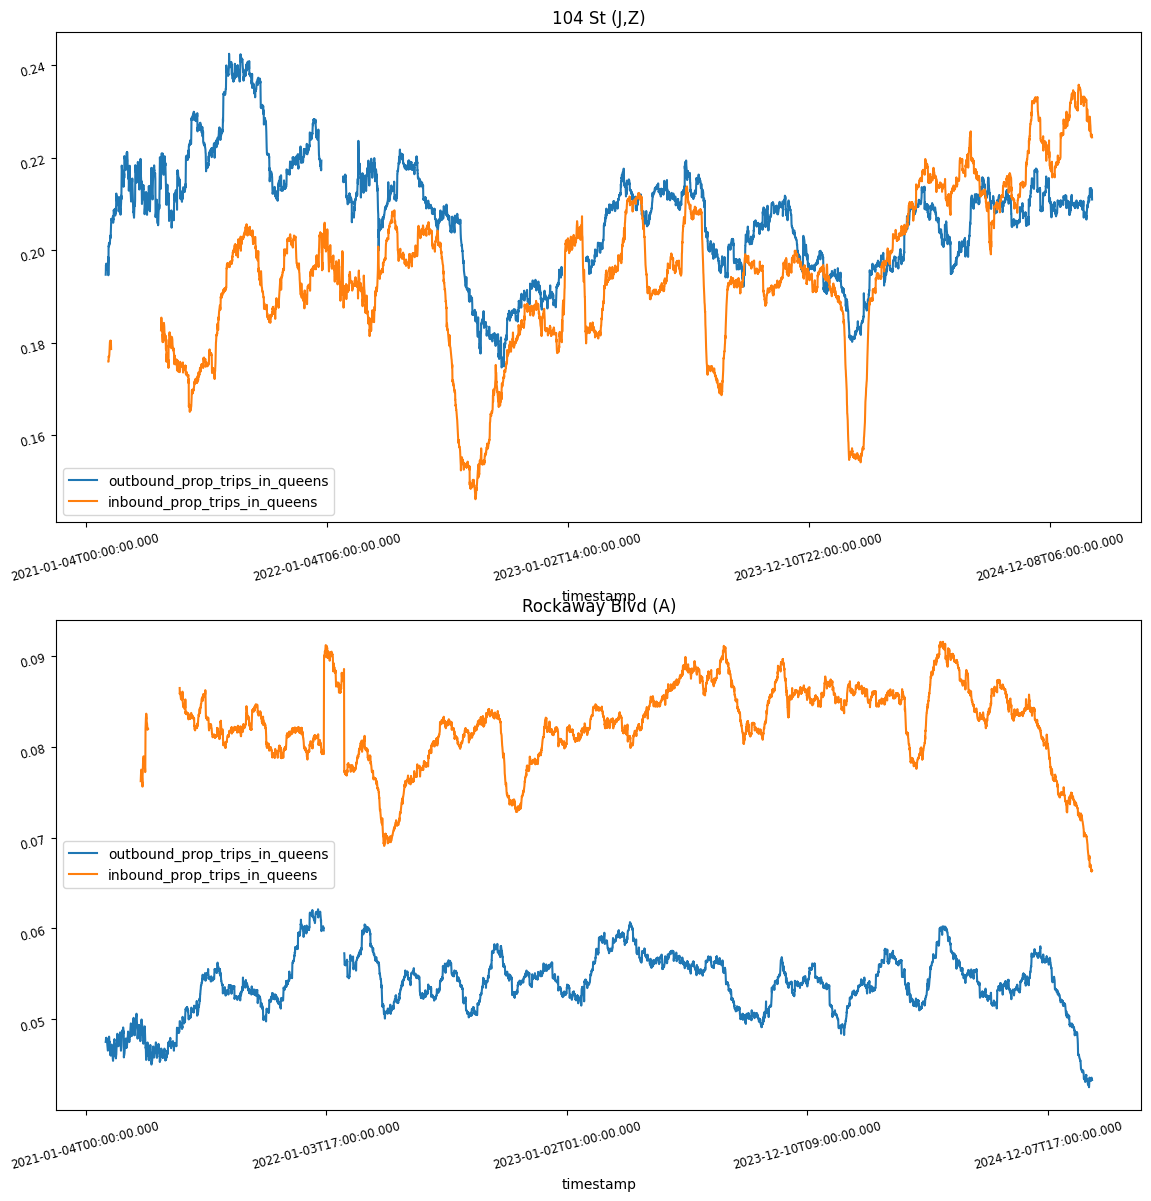

In [311]:
all_yrs=pd.concat(ttl,axis=0).fillna(0).reset_index()

all_yrs['outbound_prop_trips_in_queens'] = all_yrs['outbound_ridership_qns_only']/all_yrs['outbound_ridership']
all_yrs['inbound_prop_trips_in_queens'] = all_yrs['inbound_ridership_qns_only']/all_yrs['inbound_ridership']

fig,ax = plt.subplots(2,1,figsize=(14,14))

all_yrs.loc[all_yrs['name']=='104 St (J,Z)'].set_index('timestamp')[['outbound_prop_trips_in_queens','inbound_prop_trips_in_queens']]\
       .rolling(24*7)\
       .mean()\
       .plot(ax=ax[0])
ax[0].set_title('104 St (J,Z)')

all_yrs.loc[all_yrs['name']=='Rockaway Blvd (A)'].set_index('timestamp')[['outbound_prop_trips_in_queens','inbound_prop_trips_in_queens']]\
       .rolling(24*7)\
       .mean()\
       .plot(ax=ax[1])
ax[1].set_title('Rockaway Blvd (A)')

ax[0].tick_params(labelrotation=15,labelsize='small')
ax[1].tick_params(labelrotation=15,labelsize='small')

plt.show()


#### Add nearby nodes (stations) to the study area

In [5]:
centroid_stops = [82,192]
!pip install pyarrow
import math
import multiprocess as mp 
import dask.dataframe as dd

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

def compute_yearly(endpoint, station_id=['82','192']):

    def build_tbl(endpoint, payload):
        try:
            r = requests.get(
                url = endpoint, params = payload
            ) 
            return pd.read_csv(io.StringIO(r.text))
        except Exception: 
            print(r.status_code) 
            print(r.reason) 
            return pd.DataFrame() 
            
    stations_str = ','.join(station_id)
    payloads = [
        {
            '$select':'timestamp,SUM(estimated_average_ridership) as outbound_ridership',
            '$where':f"origin_station_complex_id in ({stations_str})",
            '$group':'timestamp',
            '$order':'timestamp',
            '$limit':50000
        }, 
        {
            '$select':'timestamp,SUM(estimated_average_ridership) as inbound_ridership',
            '$where':f"destination_station_complex_id in ({stations_str})",
            '$group':'timestamp',
            '$order':'timestamp',
            '$limit':50000
        }, 
        {
            '$select':'timestamp,SUM(estimated_average_ridership) as outbound_ridership_qns_only',
            '$where':f"origin_station_complex_id in ({stations_str}) and destination_station_complex_id in ({qns_stations_lst})",
            '$group':'timestamp',
            '$order':'timestamp',
            '$limit':50000
        }, 
        {
            '$select':'timestamp,SUM(estimated_average_ridership) as inbound_ridership_qns_only',
            '$where':f"destination_station_complex_id in ({stations_str}) and origin_station_complex_id in ({qns_stations_lst})",
            '$group':'timestamp',
            '$order':'timestamp',
            '$limit':50000
        }
        
    ]
    pool = mp.Pool(processes=4)
    mapped = pool.map(lambda x: build_tbl(endpoint = endpoint, payload = x), payloads)
    return mapped

lat_lon = station_metadata.groupby(['Complex ID'])[['Entrance Latitude','Entrance Longitude']]\
                          .mean() \
                          .reset_index()
centroids = lat_lon.loc[lat_lon['Complex ID'].isin(centroid_stops)]
for i,r in centroids.iterrows(): 
    ref_lat, ref_lon = r['Entrance Latitude'],r['Entrance Longitude'] 
    lat_lon[f"distance_{r['Complex ID']}"] = \
    lat_lon.apply(lambda r: haversine(ref_lat,ref_lon,r['Entrance Latitude'],r['Entrance Longitude']),axis=1)
    pass 

max_radius = 2 
study_area = lat_lon.loc[
    (lat_lon['distance_82.0'] < max_radius)
   &(lat_lon['distance_192.0'] < max_radius)
]['Complex ID'].unique() 

ttl_added_coverage=[]
for idx,en in tqdm(enumerate(endpoints_by_yr)):
    print(f'*** LOADING 202{idx+1} SUBWAY RIDERSHIP DEMAND TS DATA ***') 
    ttl_added_coverage.append(
        compute_yearly(
            endpoint = en, 
            station_id = study_area.astype(str)
        )
    )

ttl_r_2 = pd.concat([pd.concat([i.set_index('timestamp') for i in j],axis=1) for j in ttl_added_coverage],axis=0)
ttl_r_2.head(10)

0it [00:00, ?it/s]

*** LOADING 2021 SUBWAY RIDERSHIP DEMAND TS DATA ***


1it [01:51, 111.69s/it]

*** LOADING 2022 SUBWAY RIDERSHIP DEMAND TS DATA ***


2it [04:53, 152.96s/it]

*** LOADING 2023 SUBWAY RIDERSHIP DEMAND TS DATA ***


3it [08:07, 171.61s/it]

*** LOADING 2024 SUBWAY RIDERSHIP DEMAND TS DATA ***


4it [08:34, 114.68s/it]

*** LOADING 2025 SUBWAY RIDERSHIP DEMAND TS DATA ***


5it [09:06, 109.24s/it]


,outbound_ridership,inbound_ridership,outbound_ridership_qns_only,inbound_ridership_qns_only
timestamp,,,,
2021-01-04T00:00:00.000,25.4997,66.3541,2.0500,2.6916
2021-01-04T04:00:00.000,184.5029,30.4035,2.4120,1.2133
2021-01-04T05:00:00.000,1264.5641,195.2186,71.8698,17.6437
2021-01-04T06:00:00.000,1878.1346,365.2349,94.1308,39.1994
2021-01-04T07:00:00.000,2123.6346,451.7727,117.7818,41.7635
2021-01-04T08:00:00.000,1532.9656,473.3121,93.4752,46.3884
2021-01-04T09:00:00.000,887.1966,347.7784,66.5791,39.7408
2021-01-04T10:00:00.000,610.5773,316.5417,53.5521,35.6549
2021-01-04T11:00:00.000,516.6404,350.9225,48.7341,50.8378


In [6]:
ttl_r_2.to_csv('datasets/outputs/subway_travel_demand2.csv')